In [29]:
#ライブラリの読み込み

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
from numpy import nan
import seaborn as sns

#データの読み込み
df = pd.read_csv('train_taitanic.csv')

In [30]:
#欠損値を確認
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [31]:
#敬称による分類、繰り返し文{'Miss.':0,'Mrs.':1,'Master':2,'Mr':3}
#Msは1人なのでMrsに追加
#3には数人Dr.などいるがMr.として考える

list_n = []
for name in df.loc[:,['Name']].values.reshape(-1):
    if 'Miss.' in name:
        list_n.append(0)
    elif 'Mrs.' in name or 'Ms.' in name:
        list_n.append(1)
    elif 'Master.' in name:
        list_n.append(2)
    else:
        list_n.append(3)

In [32]:
#dfにHonorificカラムを追加
df['Honorific'] = np.array(list_n)

In [33]:
#敬称ごとの年齢の平均値、中央値を出力

age_mean = df.groupby('Honorific').Age.mean()
age_median = df.groupby('Honorific').Age.median()
print(age_mean)
print(age_median)

Honorific
0    21.773973
1    35.825688
2     4.574167
3    32.994090
Name: Age, dtype: float64
Honorific
0    21.0
1    35.0
2     3.5
3    30.0
Name: Age, dtype: float64


In [34]:
#Ageの欠損値を敬称ごとの平均値で補完

#Ageが欠損しているindexを取り出しのlistを作成
age_nan = df.Age.isnull()
list_nan = age_nan.values
list_t = []
for i in range(len(list_nan)):
    if list_nan[i] == True:
        list_t.append(i)
        
#list_tに対して敬称ごとの年齢の中央値が対応するlistの作成
list_m = []
for i in list_t:
    list_m.append(age_mean[df.Honorific[i]])
    
#df_ageカラムを作成し、dfに追加
df_age = df.loc[:,['Age']]
for j,k in zip(list_t, list_m):    
    df_age.Age[j] = k

df['Age_mod'] = df_age

In [35]:
#Sexをダミー変数化
df['Female'] = df['Sex'].map({'male':0,'female':1})

#Pclassをダミー変数化
#Embarkedをダミー変数化
pclass = pd.get_dummies(df['Pclass'],prefix ='Class')
embarked = pd.get_dummies(df['Embarked'], prefix='Embarked')

#df,pclass,embarkedを結合
df = pd.concat([df, pclass, embarked], axis=1)


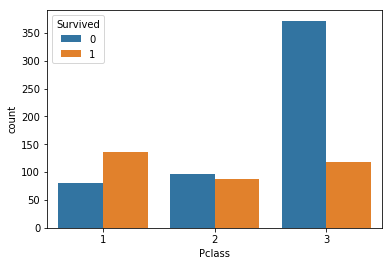

In [36]:
#それぞれの説明変数についてヒストグラムを出力

#Pclass:客室の等級,1:高級
sns.countplot(x='Pclass', hue='Survived', data=df)

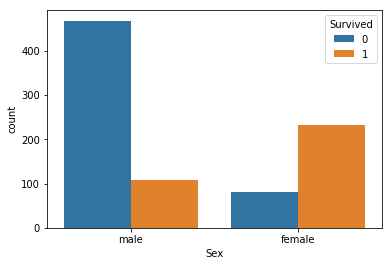

In [37]:
#Sex:性別
sns.countplot(x='Sex', hue='Survived', data=df)

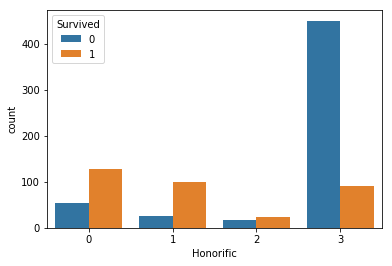

In [38]:
#Honorific:敬称{0:'Miss',1:'Mrs',2:'Master,3:'Mr'}
sns.countplot(x='Honorific', hue='Survived',data=df)

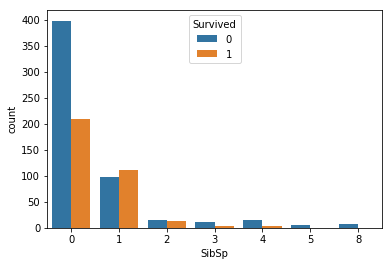

In [39]:
#SibSp:兄弟、いとこ、嫁、夫の数
sns.countplot(x='SibSp', hue='Survived', data=df,)

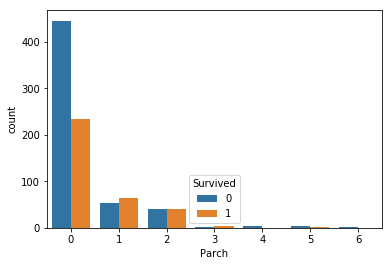

In [40]:
#Parch:両親、子供の数
sns.countplot(x='Parch', hue='Survived', data=df,)

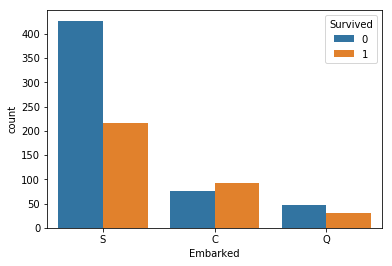

In [41]:
#Embarked:搭乗した場所
sns.countplot(x='Embarked', hue='Survived', data=df,)

([array([  20.,   27.,  128.,  104.,  175.,   46.,   24.,   15.,    9.,    1.]),
  array([ 38.,  19.,  85.,  65.,  80.,  24.,  21.,   9.,   0.,   1.])],
 array([  0.42 ,   8.378,  16.336,  24.294,  32.252,  40.21 ,  48.168,
         56.126,  64.084,  72.042,  80.   ]),
 <a list of 2 Lists of Patches objects>)

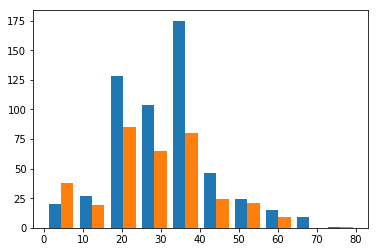

In [42]:
split_data = []
for survived in [0,1]:
    split_data.append(df[df.Survived==survived])

age_l = [i['Age_mod'].dropna() for i in split_data]
plt.hist(age_l, histtype='bar', bins=10)

([array([ 468.,   45.,   22.,    5.,    3.,    0.,    3.,    3.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.]),
  array([ 219.,   45.,   39.,   17.,    8.,    0.,    6.,    5.,    0.,
            0.,    0.,    0.,    0.,    0.,    3.])],
 array([   0.     ,   34.15528,   68.31056,  102.46584,  136.62112,
         170.7764 ,  204.93168,  239.08696,  273.24224,  307.39752,
         341.5528 ,  375.70808,  409.86336,  444.01864,  478.17392,
         512.3292 ]),
 <a list of 2 Lists of Patches objects>)

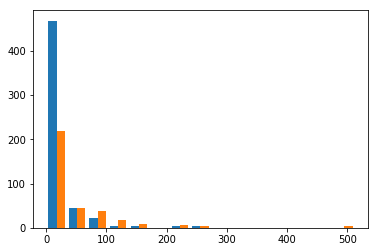

In [43]:
fare_l = [i['Fare'].dropna() for i in split_data]
plt.hist(fare_l, histtype='bar', bins=15)

In [44]:
#Embarkedに欠損値を持つサンプルを削除
df = df.dropna(subset=['Embarked'])

#不必要なPassengerId,Name,Age,Ticket,Cabin,Embarkedを説明変数から削除
#多重共線性を防ぐためにClass_3,Embarked_Qを削除
df = df.drop(['PassengerId','Pclass','Name','Sex','Embarked',
              'Age','Ticket','Cabin','Class_3','Embarked_Q'], axis=1)

In [66]:
df.columns

Index(['Survived', 'SibSp', 'Parch', 'Fare', 'Honorific', 'Age_mod', 'Female',
       'Class_1', 'Class_2', 'Embarked_C', 'Embarked_S'],
      dtype='object')

In [46]:
#欠損値処理　終了　     ↑↑↑
#モデル学習、実行　開始　↓↓↓

In [47]:
#ライブラリの読み込み
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [48]:
#説明変数と目的変数を指定
#全て使ってみる
X_0 = df.drop(['Survived'], axis=1).values
y_0 = df.loc[:,['Survived']].values.reshape(-1)

#データの分割
X_0_train, X_0_test, y_0_train, y_0_test = train_test_split(X_0, y_0, test_size=0.3, 
                                                                random_state=0)

In [64]:
#ロジスティック回帰の実行
#カーネルSVCの実行

lr_0 = LogisticRegression(C=1.0)
lr_0.fit(X_0_train, y_0_train)
svc_0 = SVC(kernel='rbf', gamma=0.0001, C=100)
svc_0.fit(X_0_train, y_0_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [65]:
#決定係数を出力
print(lr_0.score(X_0_train, y_0_train))
print(lr_0.score(X_0_test, y_0_test))
print(svc_0.score(X_0_train, y_0_train))
print(svc_0.score(X_0_test, y_0_test))

0.819935691318
0.775280898876
0.810289389068
0.74531835206


In [51]:
#　運賃∝客室の等級
#  敬称　＝　性別　＋　(年齢)

In [62]:
#説明変数を絞る
#Female,Age_mod,Class_1,Class_2,Embarked_C,Embarked_Sを抽出
X_1 = df.loc[:,['Female','Age_mod','Class_1','Class_2','Embarked_C', 'Embarked_S','SibSp']].values
y_1 = df.loc[:,['Survived']].values.reshape(-1)

#データの分割
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.3, 
                                                                random_state=3)

#ロジスティック回帰の実行
#カーネルSVCの実行
lr_1 = LogisticRegression(C=1.0)
lr_1.fit(X_1_train, y_1_train)
svc_1 = SVC(kernel='rbf', gamma=0.001, C=100)
svc_1.fit(X_1_train, y_1_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [63]:
#決定係数を出力
print(lr_1.score(X_1_train, y_1_train))
print(lr_1.score(X_1_test, y_1_test))
print(svc_1.score(X_1_train, y_1_train))
print(svc_1.score(X_1_test, y_1_test))

0.834405144695
0.756554307116
0.826366559486
0.797752808989
